In [209]:
# make a transaction function
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn

In [210]:
class OptionsOptimizer(nn.Module): # setting up neural network
    def __init__(self, derivatives): # takes in derivatives as parmeters
        super(OptionsOptimizer, self).__init__() 
        self.derivatives = derivatives # derivatives inputed
        self.theta = torch.rand(len(derivatives), requires_grad=True) # target

    def forward(self, x): # when we run forward we need to provide input prices for neural network to run
        derivatives_payoff = [
            [d.payoff_fun(sample) for d in self.derivatives] for sample in x 
        ] # for each sample in x we are evaluating each payoff for d in self.derivatives 
        derivatives_payoff_tensor = torch.tensor(derivatives_payoff) # create a tensor of all the derivative payoffs
        out = torch.sum(self.theta * derivatives_payoff_tensor, dim=1) # multiply the derivative payoff by the theta
        return out

In [193]:
class Liquidity_Pnl:
    def __init__(self, token0, token1, price0, price1, ticklower, tickupper):
        self.token0 = token0 #  number of btc
        self.token1 = token1 # number of usdc
        self.price0 = price0 # price of btc
        self.price1 = price1 # price of usdc
        self.lower = (1.0001**ticklower) * 10**2 # lower bound
        self.upper = (1.0001**tickupper) * 10**2 # upper bound 
        self.balance = (token0 * token1) ** 0.5 # sqrt k 
        self.check = token0 * token1
        self.price_list = []
    def notional(self):
        notional = None
        if self.price0 < self.lower:
            notional = self.token0
        elif self.lower < self.price0 < self.upper:
            notional = (self.token0
                        * (self.price0 / self.lower) ** 0.5 
                        * (self.upper**0.5 - self.lower**0.5) 
                        / (self.upper ** 0.5 
                           - self.price0 ** 0.5
                          )
                       ) 
        else: 
            notional = self.token1 / (
                (self.lower * self.upper)**0.5
            )
        return notional  
        
    def token0_amount(self, final_price):
        if final_price <= self.lower:
            amount_a = self.notional()
            amount_b = 0
        elif self.lower < final_price < self.upper:
            amount_a = (self.notional() * (self.lower / final_price)**0.5 
            * ((self.upper) ** 0.5 - (final_price) ** 0.5)
            / ( 
                (self.upper) ** 0.5
                - (self.lower) ** 0.5
            )
                       )
            amount_b = (
                self.notional()
                * ((self.lower * self.upper) ** 0.5)
                * (((final_price) ** 0.5) - ((self.lower) ** 0.5))
                / (
                    (self.upper) ** 0.5
                    - (self.lower) ** 0.5
                )
            )
        else:
            amount_a = 0
            amount_b = (
                self.notional() * (self.lower * self.upper) ** 0.5 
            )
        return (amount_a * final_price) + amount_b 
    
    def calculate_pnl(self):
        self.price_list = []
        adam_list = []
        for i in range(0, 100000):
            final_price = i 
            pnl = (self.token0_amount(final_price) 
                   - (self.token0 * self.price0 + self.token1))
            adam_list.append(pnl)
            self.price_list.append(final_price)
        return adam_list

    def above(self):
        high_values = [pnl if pnl > 0 else 0 for pnl in self.calculate_pnl()]
        return high_values

    def beneath(self):
        low_values = [pnl if pnl < 0 else 0 for pnl in self.calculate_pnl()]
        return low_values
        
    def plot(self):
        plt.figure(figsize=(12,8))
        plot = plt.scatter(self.price_list, self.calculate_pnl(), c='b', s=4)
        plt.xlabel('Final Price')
        plt.ylabel('Pnl ($)')
        plt.title('Liquidity Position Pnl')
        # Adding a horizontal dotted line at y=0
        plt.axhline(y=0, color='black', linestyle='--', xmax= 1)
        plt.fill_between(self.price_list, self.above(), color='Limegreen', alpha=0.4)
        plt.fill_between(self.price_list, self.beneath(), color='LightCoral', alpha=0.4)
        return plot

In [213]:
x = Liquidity_Pnl(19.94218148, 265132.506276, 23776, 1, 51960, 59940)
x.calculate_pnl()

[-739277.81314448,
 -739245.0582904799,
 -739212.3034364799,
 -739179.5485824798,
 -739146.7937284798,
 -739114.0388744798,
 -739081.2840204798,
 -739048.5291664797,
 -739015.7743124797,
 -738983.0194584796,
 -738950.2646044795,
 -738917.5097504795,
 -738884.7548964794,
 -738852.0000424794,
 -738819.2451884794,
 -738786.4903344794,
 -738753.7354804793,
 -738720.9806264793,
 -738688.2257724792,
 -738655.4709184791,
 -738622.7160644791,
 -738589.961210479,
 -738557.206356479,
 -738524.451502479,
 -738491.696648479,
 -738458.9417944789,
 -738426.1869404789,
 -738393.4320864788,
 -738360.6772324787,
 -738327.9223784787,
 -738295.1675244786,
 -738262.4126704786,
 -738229.6578164786,
 -738196.9029624786,
 -738164.1481084785,
 -738131.3932544785,
 -738098.6384004784,
 -738065.8835464783,
 -738033.1286924783,
 -738000.3738384782,
 -737967.6189844783,
 -737934.8641304782,
 -737902.1092764782,
 -737869.3544224781,
 -737836.5995684781,
 -737803.844714478,
 -737771.089860478,
 -737738.3350064779,


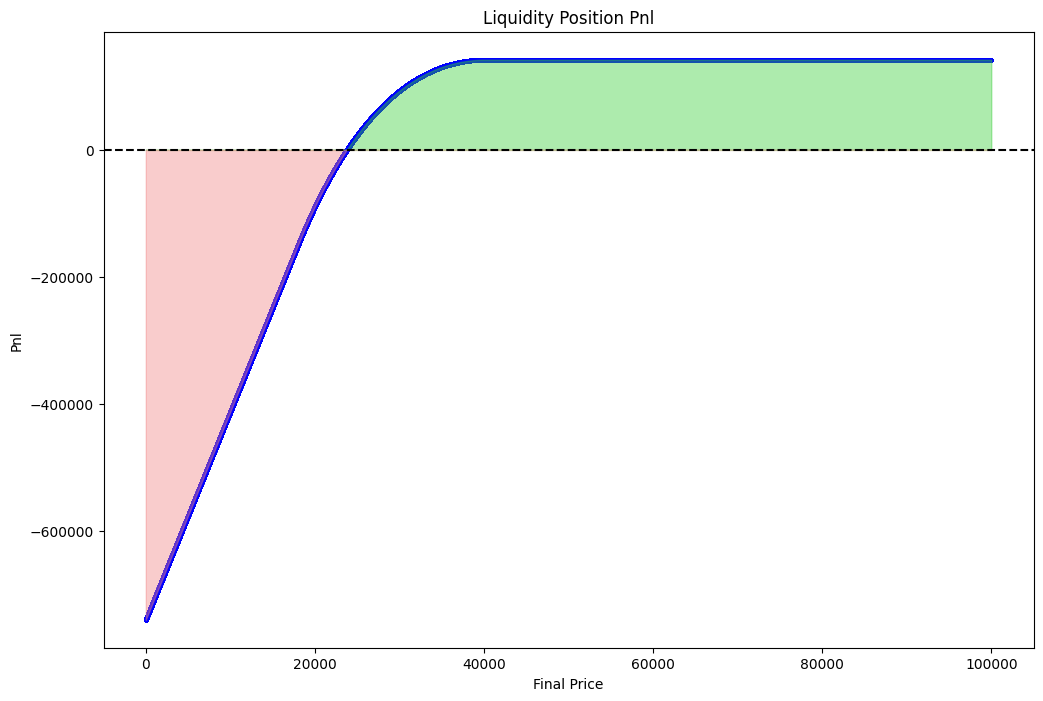

In [207]:
x.plot()

In [ ]:
class Train:
    def __init__(self, 